In [1]:
import json
from pathlib import Path
import numpy as np

from plot_utils import plot_sample, plot_sample_from_rttm

/home/heh/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
[NeMo W 2022-10-27 15:49:52 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-10-27 15:49:52 experimental:27] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-10-27 15:49:52 experimental:27] Module <class 'nemo.collections.nlp.models.text_normalization_as_tagging.thutmose_tagger.ThutmoseTaggerModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
# root_dir = Path("../nemo_experiments/Stream_VAD/drc_Multilang_sgdlr1e-3_wd1e-4_augx_b128_gacc1_ep50_w8/frame_vad_output/")
root_dir = Path("../nemo_experiments/checkpoints/")
test_folder = root_dir / Path("vad_output_ch120_CH109_eval_10ms")


manifest_file = test_folder / Path("manifest_vad_input.json")
pred_frame_dir = test_folder / Path("frame_predictions")
gt_frame_dir = test_folder / Path("frames_groundtruth")

In [3]:
def load_manifest(manifest_file):
    results = {}
    with Path(manifest_file).open("r") as fin:
        for line in fin.readlines():
            item = json.loads(line.strip())
            audio_file = item["audio_filepath"]
            key = Path(audio_file).stem
            results[key] = audio_file
    return results

def load_frames(data_dir):
    results = {}
    for frames_file in Path(data_dir).glob("*.frame"):
        key = frames_file.stem
        results[key] = str(frames_file)
    return results


In [9]:
audio_dict = load_manifest(manifest_file)
pred_frame_dict = load_frames(pred_frame_dir)
gt_frame_dict = load_frames(gt_frame_dir)

In [22]:
post_args = {
    "onset": 0.5, # onset threshold for detecting the beginning and end of a speech
    "offset": 0.8, # offset threshold for detecting the end of a speech.
    "pad_onset": 0.0, # adding durations before each speech segment
    "pad_offset": 0.0, # adding durations after each speech segment
    "min_duration_on": 0.0, # threshold for small non_speech deletion
    "min_duration_off": 0.2, # threshold for short speech segment deletion
    "filter_speech_first": True, 
    "frame_length_in_sec": 0.01
}
duration = None

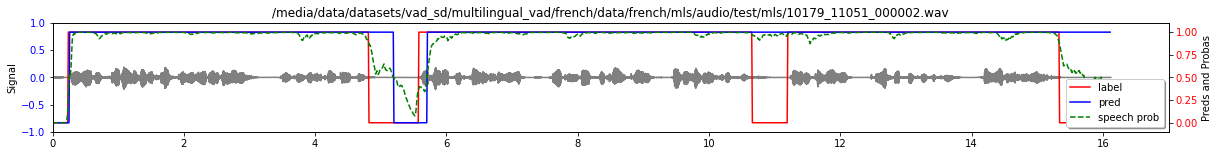

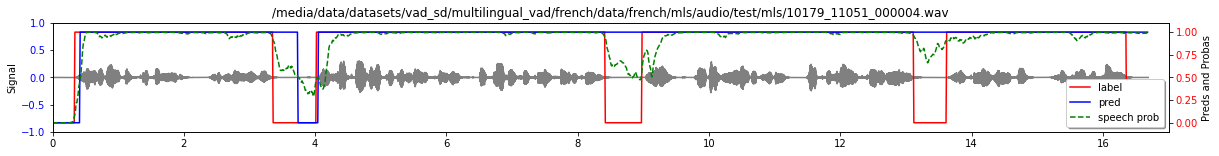

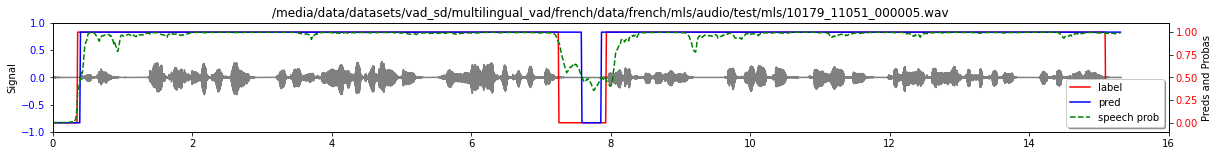

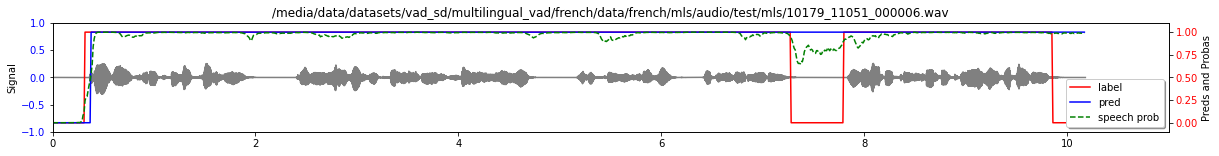

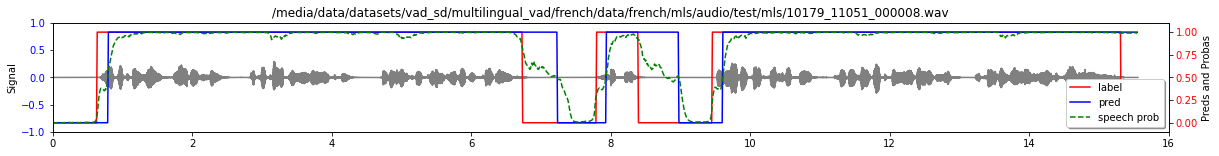

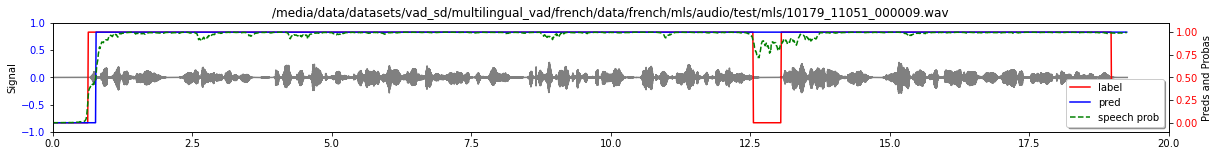

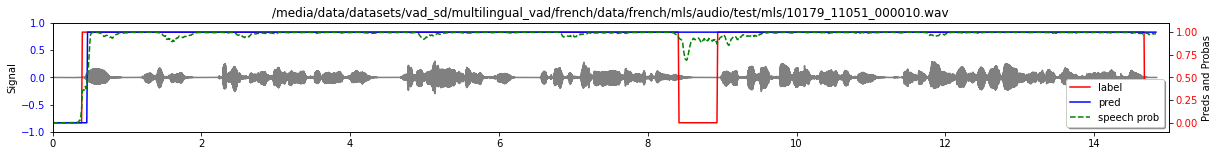

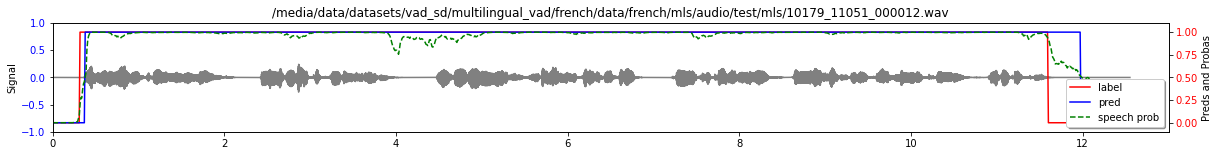

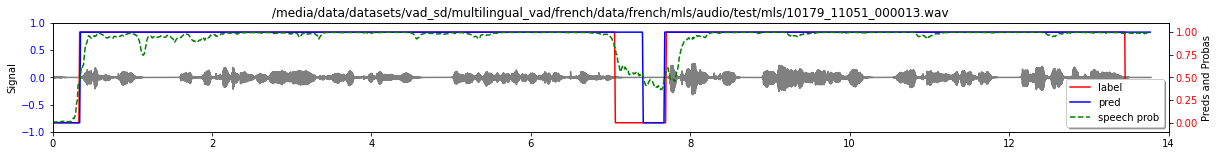

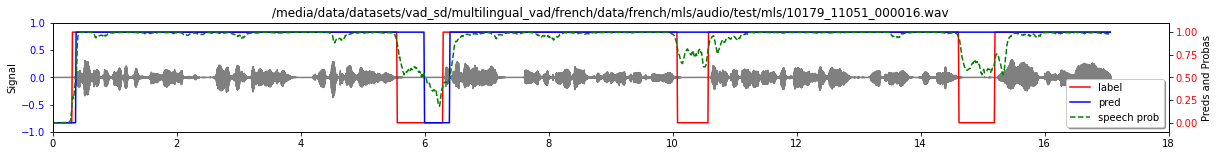

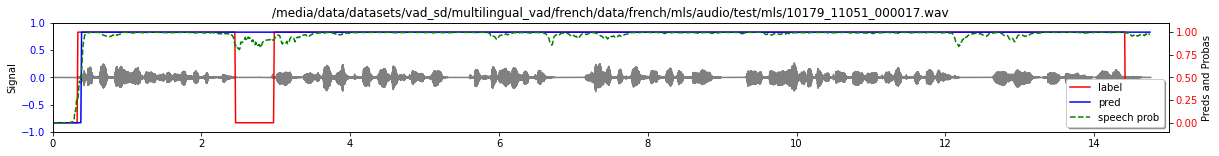

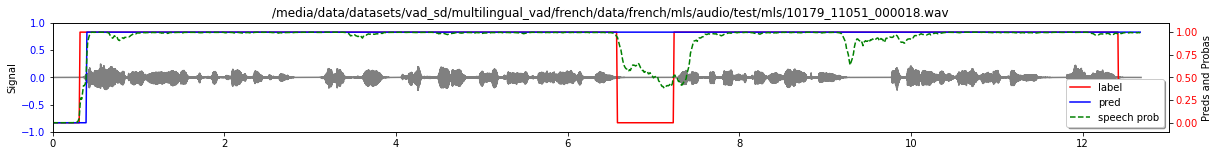

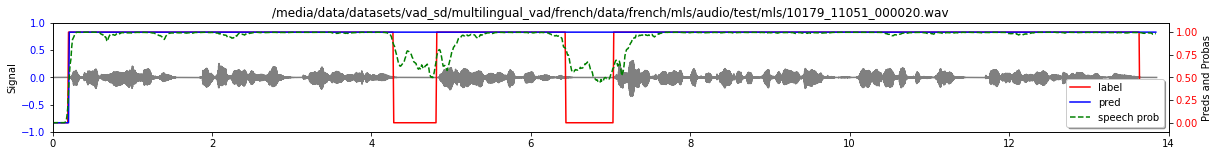

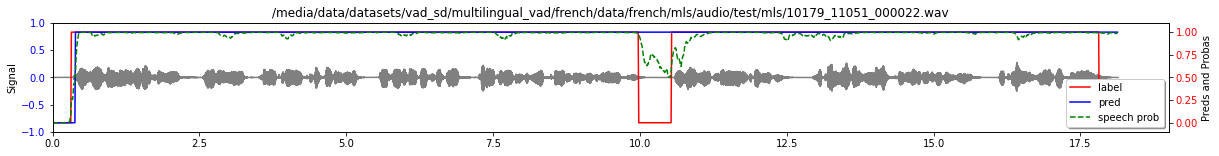

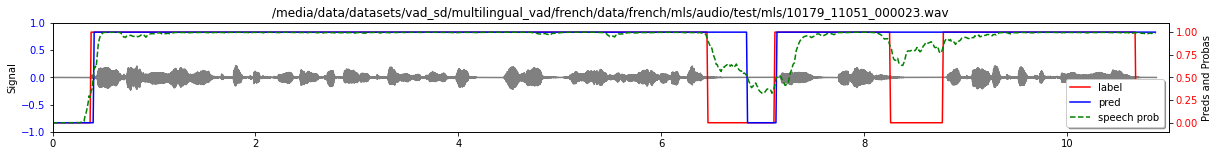

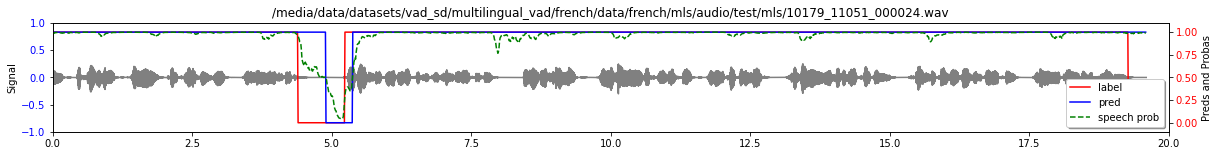

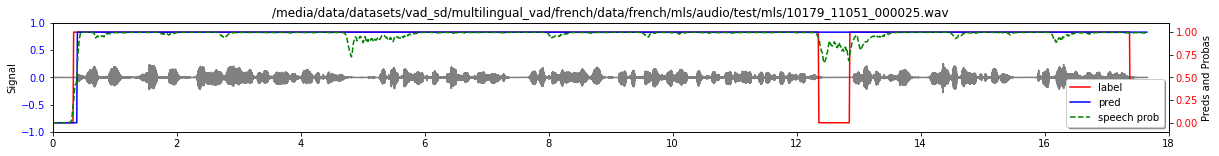

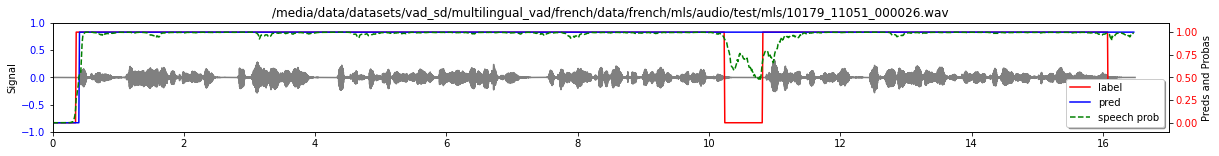

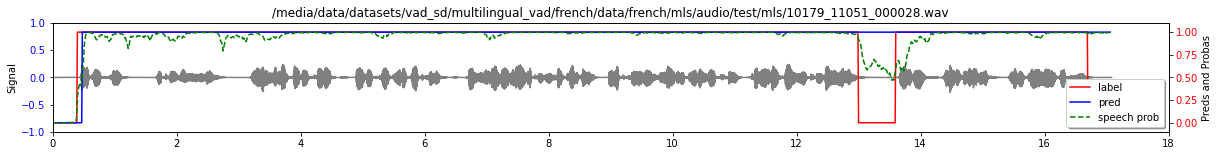

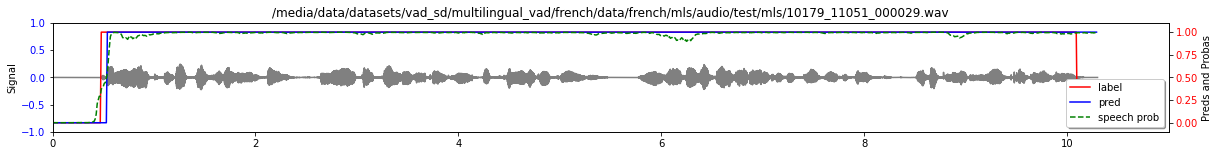

In [23]:
num_samples = 20
all_keys = sorted(list(audio_dict.keys()))
keys_sampled = all_keys[:num_samples] #np.random.choice(all_keys, num_samples)
for key in keys_sampled:
    plot_sample(audio_dict[key], pred_frame_dict[key], gt_frame_dict[key], per_args=post_args, duration=duration)
    


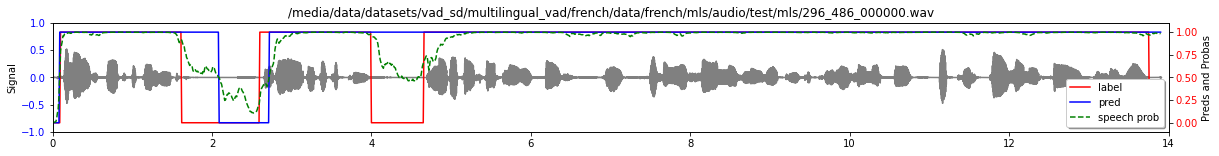

<Figure size 432x288 with 0 Axes>

In [11]:
key = "296_486_000000"
plot_sample(audio_dict[key], pred_frame_dict[key], gt_frame_dict[key], per_args=post_args)

In [9]:
import IPython.display as ipd
import json
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Dict, List, Optional
from pathlib import Path

def plot_sample_from_manifest(data: Dict, max_duration: Optional[float] = None, save_path: str = "", repeat: int = 1):
    audio_file = data['audio_filepath']
    labels = [float(x) for x in data['label'].split()]
    
    if repeat > 1:
        labels = np.repeat(labels, repeat)
    
    duration = data['duration']
    offset = data.get('offset', 0.0)

    if max_duration:
        duration = min(duration, max_duration)

    plt.figure(figsize=[20, 2])
    UNIT_FRAME_LEN = 0.01

    audio, sample_rate = librosa.load(path=audio_file, sr=16000, mono=True, offset=offset, duration=duration)
    dur = librosa.get_duration(y=audio, sr=sample_rate)

    time = np.arange(offset, offset + dur, UNIT_FRAME_LEN)

    length = len(labels)
    ax1 = plt.subplot()
    ax1.set_title(audio_file)
    ax1.plot(np.arange(audio.size) / sample_rate, audio, 'gray')
    ax1.set_xlim([0, int(dur) + 1])
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylabel('Signal')
    ax1.set_ylim([-1, 1])
    ax2 = ax1.twinx()

    ax2.plot(np.arange(length) * UNIT_FRAME_LEN, labels, 'r', label='label')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend(loc='lower right', shadow=True)
    ax2.set_ylabel('Labels')
    ax2.set_ylim([-0.1, 1.1])
    plt.show()
    if save_path != "":
        plt.savefig(save_path)
    return ipd.Audio(audio, rate=16000)

def load_manifest_data(manifest_file):
    results = []
    with Path(manifest_file).open("r") as fin:
        for line in fin.readlines():
            item = json.loads(line.strip())
            results.append(item)
    return results

In [11]:
fisher_manifest = "/media/data/projects/NeMo-vad-1_10-22_05/vad_code/manifests_local/fisher_2004_40ms_local.json"
fisher_data = load_manifest_data(fisher_manifest)

In [6]:
manifest_file = "/media/data/projects/NeMo-fvad/vad_code/manifests_cleaned/train/mandarin_train_40ms_local_cleaned.json"
manifest_data = load_manifest_data(manifest_file)


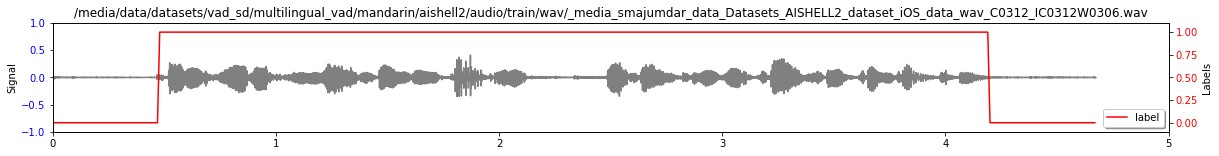

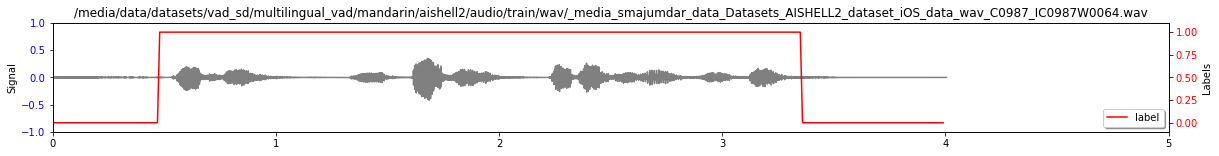

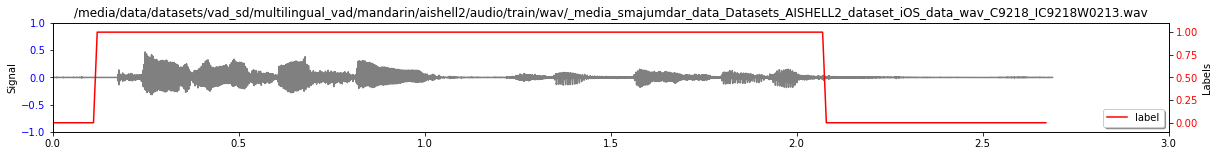

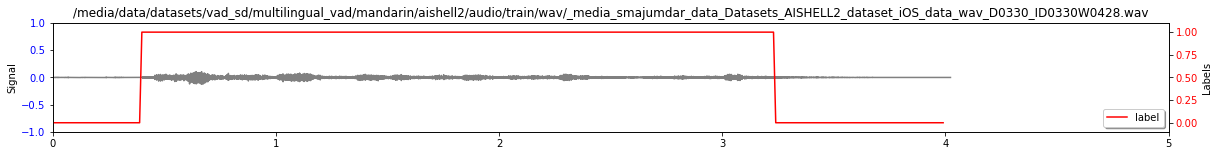

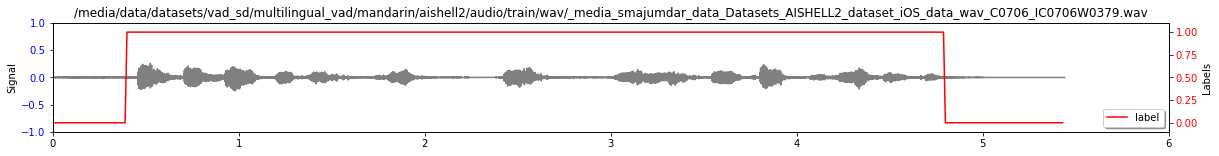

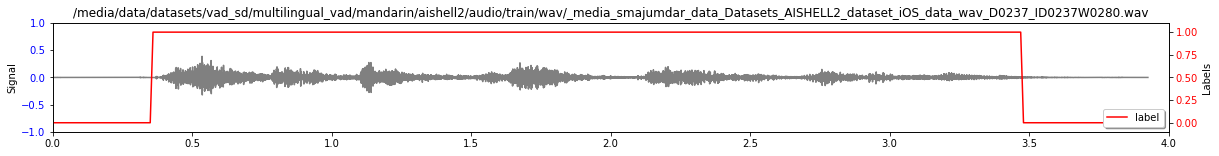

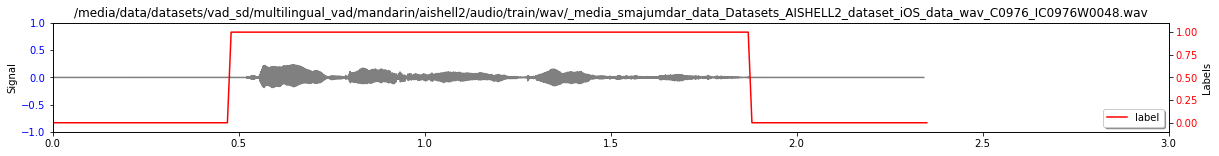

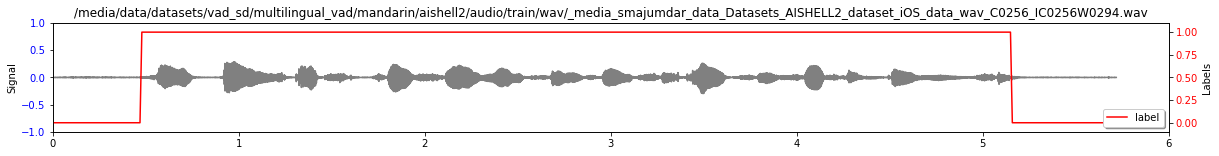

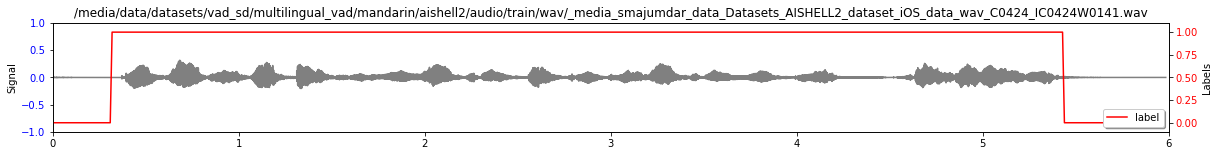

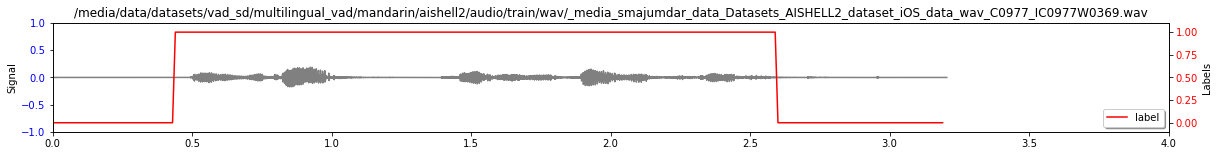

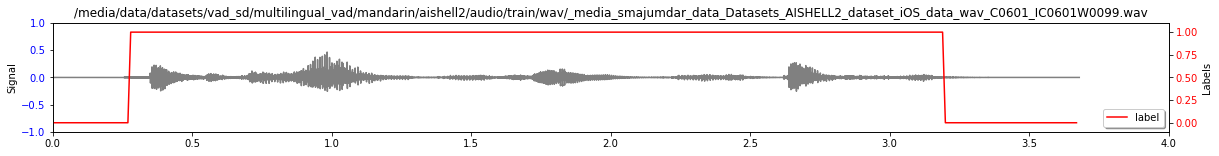

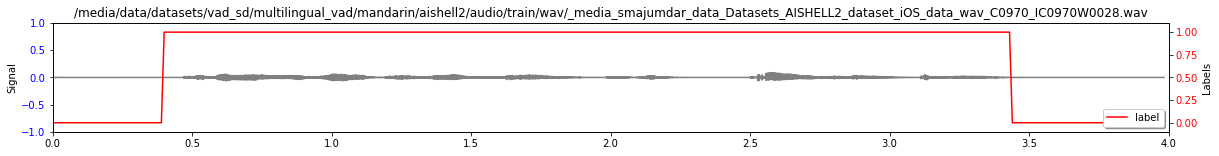

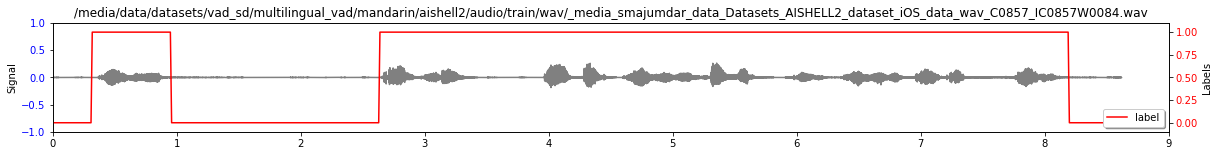

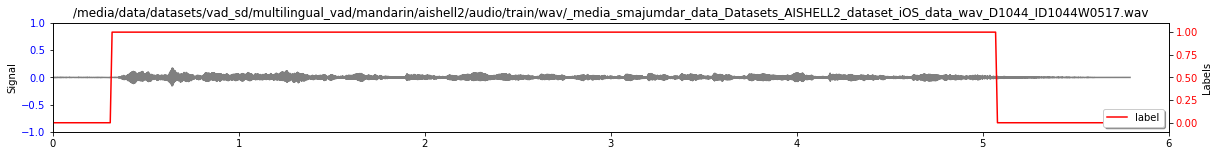

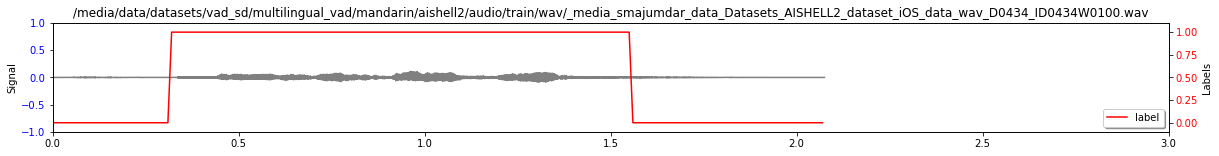

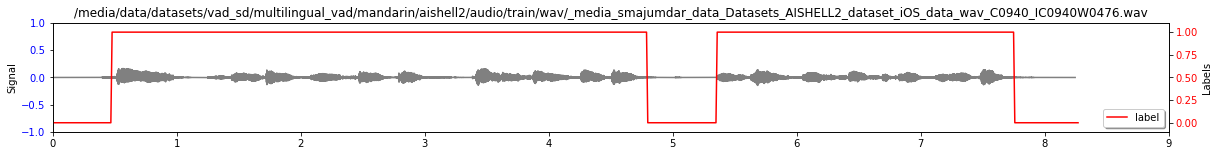

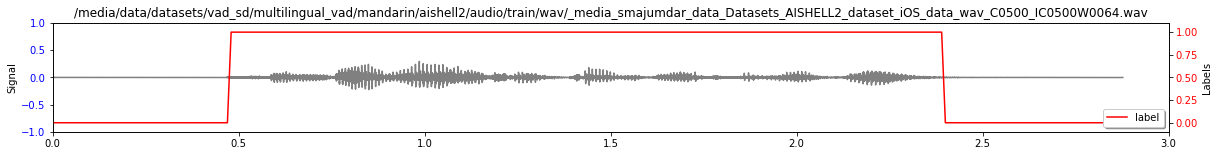

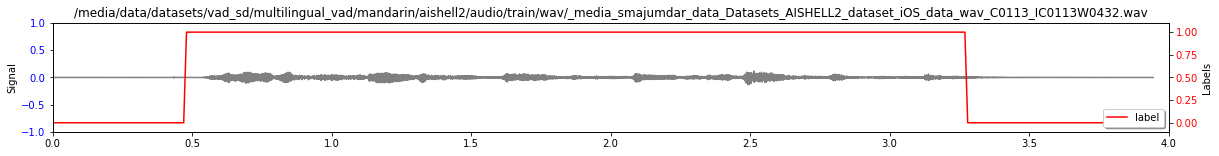

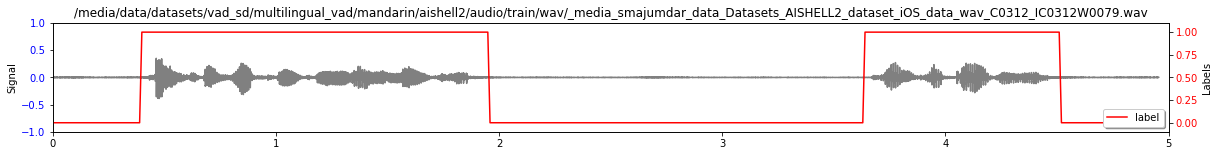

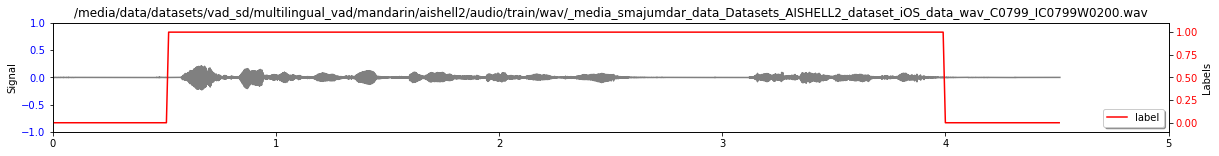

In [10]:
indices = np.random.permutation(len(manifest_data))
for idx in indices[:20]:
    plot_sample_from_manifest(manifest_data[idx], max_duration = 30, repeat = 4)

In [9]:
sample_path = "/media/data/datasets/vad_sd/fisher/audio_2004/"

'/media/data/datasets/vad_sd/fisher/audio_2004/fe_03_04159.wav'

In [ ]:
manifest_dir = Path("/media/data/projects/NeMo-fvad/vad_code/manifests_cleaned/train/")
rttm_root = Path("/media/data2/datasets/multilang_vad_ctm")

manifest_list = [
    manifest_dir / "french_train_40ms_local_cleaned.json",
    manifest_dir / "german_train_40ms_local_cleaned.json",
    manifest_dir / "russian_train_40ms_local_cleaned.json",
    manifest_dir / "spanish_train_40ms_local_cleaned.json",
    manifest_dir / "mandarin_train_40ms_local_cleaned.json",
]
for manifest_file in manifest_list:
    data_dir = rttm_root / manifest_file.stem.split("_")[0]